In [1]:
import torch
import torch.autograd as autograd         
import torch.nn as nn                     
import torch.optim as optim               
import matplotlib.pyplot as plt
import numpy as np
import time
import scipy as sp
from scipy.integrate import odeint
import pandas as pd

torch.set_default_dtype(torch.double)
torch.manual_seed(1234)
np.random.seed(1234)

# Deep Neural Network

In [2]:
class DNN(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.activation = nn.Tanh()
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i + 1]) for i in range(len(layers) - 1)])

        for i in range(len(layers) - 1):
            nn.init.xavier_uniform_(self.linears[i].weight.data, gain=1.0)
            nn.init.zeros_(self.linears[i].bias.data)

    def forward(self, x):
        for i in range(len(layers) - 2):
            z = self.linears[i](x)
            x = self.activation(z)

        x = self.linears[-1](x)
        return x

# Physics-inspired Neural Network

In [3]:
class FCN():
    def __init__(self, layers):
        'Initialize iterator'
        self.iter = 0
        'Initialize parameters (Inverse problem)' 
        self.alpha = torch.tensor([alpha], requires_grad=True).double()
        self.beta = torch.tensor([beta], requires_grad=True).double() 
        self.tau = torch.tensor([tau], requires_grad=True).double() 
        'Register parameters to optimize'
        self.alpha = nn.Parameter(self.alpha)
        self.beta = nn.Parameter(self.beta)
        self.tau = nn.Parameter(self.tau)
        'Call the DNN'
        self.dnn = DNN(layers)
        'Register parameters'
        self.dnn.register_parameter('alpha', self.alpha)
        self.dnn.register_parameter('beta', self.beta)
        self.dnn.register_parameter('tau', self.tau)  
        'Loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
        
    def loss_initial(self,x,y):
        loss_in = self.loss_function(self.dnn(x), y)
        return loss_in
            
    def loss_data(self,x,y):
        loss_u = self.loss_function(self.dnn(x), y) 
        return loss_u
        
    def loss_ODE(self, x):
        alpha = self.alpha
        beta = self.beta
        tau = self.tau
        
        g = x.clone()           
        g.requires_grad = True
        
        u = self.dnn(g) # u is the output of the network
        v0 = u[:,0].view(-1, 1)
        p1 = u[:,1].view(-1, 1)
        v1 = u[:,2].view(-1, 1)

        v0_dot = autograd.grad(u[:, 0], g, torch.ones_like(u[:, 0]), create_graph=True)[0]
        p1_dot = autograd.grad(u[:, 1], g, torch.ones_like(u[:, 1]), create_graph=True)[0]
        v1_dot = autograd.grad(u[:, 2], g, torch.ones_like(u[:, 2]), create_graph=True)[0]
        
        f_p1 = p1_dot - (v0 - v1)
        f_v1 = v1_dot - alpha * (p1 - tau * v1) - beta * (v0 - v1)
            
        loss_f_p1 = self.loss_function(f_p1, f_hat)
        loss_f_v1 = self.loss_function(f_v1, f_hat)
        
        return loss_f_p1 + loss_f_v1
    
    def loss(self,x0,y0,x,y):
        loss_in = self.loss_initial(x0,y0)
        loss_u = self.loss_data(x,y)
        loss_f = self.loss_ODE(x)
        loss_val = lambda1*loss_in + lambda2*loss_u + lambda3*loss_f
        return loss_val

## ODEs:

\begin{align*}
\dot{p}_{i}(t) &= v_{i-1}(t) - v_i(t) \\
\dot{v}_{i}(t) &= \alpha_{i} [p_{i}(t) - \tau_{i} v_{i}(t)] + \beta_{i} [v_{i-1}(t) - v_i(t)]
\end{align*}

# Data

In [4]:
pd.set_option('display.max_columns', None)

# Read the available data from Ispra-Casale
Data = pd.read_csv('part7.csv', header=None, low_memory=False)

# Data processing
Data = Data.loc[5:, :].reset_index(drop=True)
Data.columns = Data.iloc[0]
Data = Data.iloc[1:].reset_index(drop=True)
Data = Data.drop(columns={'Lat1', 'Lon1', 'E1', 'N1', 'Lat2', 'Lon2', 'E2', 'N2', 'U2', 'Driver2', 'Alt2'})
Data = Data.astype('float64')
Data.rename(columns = {'Time':'$t$', 'Speed1':'$v_0$', 'IVS1':'$p_1$', 'Speed2':'$v_1$'}, inplace = True)
Data = Data.loc[:,['$t$','$v_0$','$p_1$', '$v_1$']]
Data['$t$'] = Data['$t$'] - Data._get_value(0, '$t$')

# Select time interval 
Time_interval = 300
Data = Data.loc[:Time_interval*10, :]

# Select the number of time points and their observations for the data loss
Data_new = Data.loc[::1, :] # 3001 points
Data_new = Data_new.reset_index(drop=True)
Data_new

,$t$,$v_0$,$p_1$,$v_1$
0,0.0,21.207972,20.252550,21.308
1,0.1,21.228550,20.256435,21.314
2,0.2,21.292856,20.245869,21.395
3,0.3,21.342757,20.257832,21.274
4,0.4,21.392143,20.257023,21.308
...,...,...,...,...
2996,299.6,31.588947,34.382937,30.900
2997,299.7,31.559109,34.442483,30.845
2998,299.8,31.548820,34.512691,30.874
2999,299.9,31.553450,34.583341,30.853


In [5]:
# Save data in a numpy.ndarray 
X_true = Data_new['$t$'].to_numpy()
U_true = Data_new[['$v_0$','$p_1$', '$v_1$']].to_numpy()

# Total number of data points
total_points = len(X_true)

# Total number of collocation points
N_f = len(X_true)

# Obtain random points for the interior
id_f = np.random.choice(total_points, N_f, replace=False)
X_train_Nu = X_true[id_f]
U_train_Nu = U_true[id_f]

# Convert arrays to tensors
X_train_Nu = torch.from_numpy(X_train_Nu).double() 
U_train_Nu = torch.from_numpy(U_train_Nu).double()

X_true = torch.from_numpy(X_true).double()
U_true = torch.from_numpy(U_true).double()

f_hat = torch.zeros(X_train_Nu.shape[0], 1)

X_train_Nu = X_train_Nu.view(-1, 1)
X_true = X_true.view(-1, 1)

# Training

In [6]:
# Initial parameter values
alpha = 1.0 
beta = 1.0 
tau = 1.0 

# Iterations 
iterations = 60001 
# Learning rate
lr = 1e-3 
# Network architecture
layers = np.array([1, 60, 60, 60, 3]) 

lambda1 = 1 # Initial condition
lambda2 = 1 # Data
lambda3 = 1 # ODEs

PINN = FCN(layers)
params = list(PINN.dnn.parameters())

alpha_values = []
beta_values = []
tau_values = []
loss_values = []

# Adam Optimizer
optimizer = torch.optim.Adam(params, lr=lr)
start_time = time.time()

# Training loop
for i in range(iterations):
    optimizer.zero_grad()
    loss = PINN.loss(X_true[0], U_true[0], X_train_Nu, U_train_Nu)  
    loss.backward()
    optimizer.step()
    
    alpha_values.append(PINN.alpha.item())
    beta_values.append(PINN.beta.item())
    tau_values.append(PINN.tau.item())    
    loss_values.append(loss.item())

    if i % 1000 == 0:
        print(f'i={i}, '
              f'Loss: {loss.item()}, '
              f'[α, β, τ] = '
              f'[{PINN.alpha.item():.5f}, '
              f'{PINN.beta.item():.5f}, '
              f'{PINN.tau.item():.5f}]')

elapsed = time.time() - start_time
print('Training time: %.2f sec' % (elapsed))

i=0, Loss: 2385.0880486400592, [α, β, τ] = [1.00100, 0.99900, 0.99900]
i=1000, Loss: 291.6100459454786, [α, β, τ] = [0.39071, 1.12357, 1.39202]
i=2000, Loss: 268.36959820190555, [α, β, τ] = [0.00847, 0.90986, 1.51517]
i=3000, Loss: 209.19022061746722, [α, β, τ] = [0.00562, 0.49700, 1.51604]
i=4000, Loss: 110.62266520847177, [α, β, τ] = [0.00515, 0.26970, 1.51749]
i=5000, Loss: 55.84089416605461, [α, β, τ] = [0.00481, 0.17390, 1.51147]
i=6000, Loss: 16.676014918350077, [α, β, τ] = [0.00621, 0.13219, 1.51725]
i=7000, Loss: 8.239185640111998, [α, β, τ] = [0.00727, 0.11047, 1.50533]
i=8000, Loss: 3.507439775014898, [α, β, τ] = [0.00848, 0.09821, 1.48665]
i=9000, Loss: 2.1241262228446254, [α, β, τ] = [0.00944, 0.08482, 1.49449]
i=10000, Loss: 1.4015057406662375, [α, β, τ] = [0.00968, 0.08236, 1.49706]
i=11000, Loss: 1.4501770401053544, [α, β, τ] = [0.00982, 0.07974, 1.50123]
i=12000, Loss: 1.9952499327512911, [α, β, τ] = [0.01009, 0.07707, 1.50830]
i=13000, Loss: 1.844911413389427, [α, β, τ

In [7]:
PINN.dnn.eval()

# Predictions for v0, p1, and v1
u_pred = PINN.dnn(X_true)
v0_pred = u_pred[:, 0].detach().numpy()
p1_pred = u_pred[:, 1].detach().numpy()
v1_pred = u_pred[:, 2].detach().numpy()

In [8]:
# Convert U_true to numpy
if isinstance(U_true, torch.Tensor):
    u_true = U_true.detach().numpy()

# Mean absolute errors (MAEs)
mae_v0 = np.mean(np.abs(u_true[:, 0] - v0_pred))
mae_p1 = np.mean(np.abs(u_true[:, 1] - p1_pred))
mae_v1 = np.mean(np.abs(u_true[:, 2] - v1_pred))

print("MAE for v0: ", mae_v0)
print("MAE for p1: ", mae_p1)
print("MAE for v1: ", mae_v1)

MAE for v0:  0.17432748156155156
MAE for p1:  0.5885693350290239
MAE for v1:  0.1934839775780535


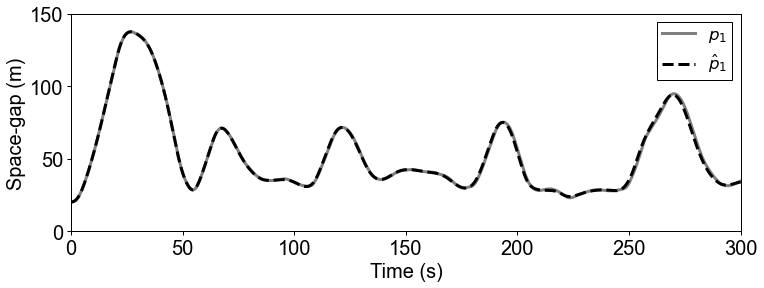

In [9]:
plt.rcParams.update({
    'font.family': 'Arial',
    'font.size': 20, 
    'axes.linewidth': 1, 
    'xtick.major.size': 4, 
    'xtick.major.width': 1, 
    'ytick.major.size': 4, 
    'ytick.major.width': 1
})

plt.figure(figsize=(12, 4))
plt.plot(X_true, u_true[:,1], linewidth=3, color='gray', label='$p_{1}$')
plt.plot(X_true, p1_pred,  '--', linewidth=3, color='black', label='$\hat{p}_{1}}$')
plt.xlim([0, 300])
plt.ylim([0, 150])
plt.xlabel("Time (s)")
plt.ylabel("Space-gap (m)")
plt.legend(
    fontsize='small', 
    fancybox=False,   
    framealpha=1,   
    shadow=False,    
    edgecolor='black', 
    borderpad=0.3,    
    loc='upper right' 
)
plt.show()

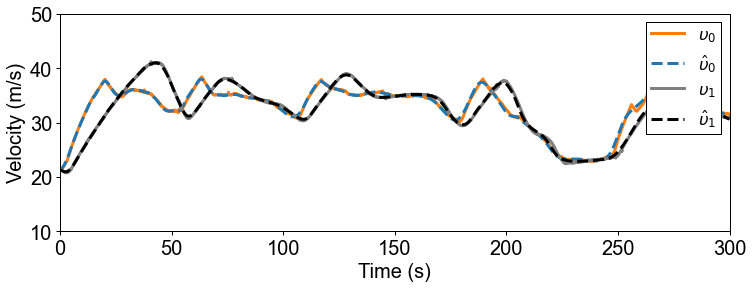

In [10]:
plt.figure(figsize=(12, 4))
plt.plot(X_true, u_true[:,0], linewidth=3, color="#ff7f0e", label='$υ_{0}}$')
plt.plot(X_true, v0_pred,  '--', linewidth=3, color = "#1f77b4", label='$\hat{υ}_{0}$')
plt.plot(X_true, u_true[:,2], linewidth=3, color="gray", label='$υ_{1}$')
plt.plot(X_true, v1_pred,  '--', linewidth=3, color = "black", label='$\hat{υ}_{1}$')
plt.xlim([0, 300])
plt.ylim([10, 50])
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.legend(
    fontsize='small', 
    fancybox=False,   
    framealpha=1,   
    shadow=False,    
    edgecolor='black', 
    borderpad=0.3,    
    loc='upper right' 
)
plt.show()

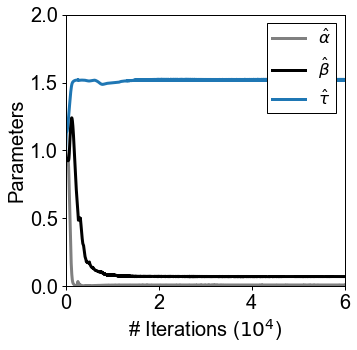

In [11]:
plt.figure(figsize=(5, 5))
plt.plot(alpha_values, label=r"$\hat{\alpha}$", linewidth=3, color = 'gray')
plt.plot(beta_values, label=r"$\hat{\beta}$", linewidth=3, color = 'black')
plt.plot(tau_values, label=r"$\hat{\tau}$", linewidth=3, color = "#1f77b4")
plt.xlim([0, iterations-1])
plt.ylim([0, 2])
plt.xticks([0, 20000, 40000, 60000], ['0', '2', '4', '6'])
plt.ylabel("Parameters")
plt.xlabel("# Iterations ($10^4$)")
plt.legend(
    fontsize='small', 
    fancybox=False,   
    framealpha=1,   
    shadow=False,    
    edgecolor='black', 
    borderpad=0.3,    
    loc='upper right' 
)
plt.show()

In [12]:
print('α = ', alpha_values[-1])
print('β = ', beta_values[-1])
print('τ = ', tau_values[-1])

α =  0.010305783308570484
β =  0.07248544367621532
τ =  1.5200721464368074


In [13]:
# Calculate L2 and Linf norms (String stability conditions)
def L2_norm(α, β, τ):
    l2 = α**2 * τ**2 + 2 * α * β * τ - 2 * α
    return l2

def Linf_norm(α, β, τ):
    linf = (α * τ + β)**2 - 4 * α
    return linf

print('L_2 norm =', L2_norm(alpha_values[-1], beta_values[-1], tau_values[-1]))
print('L_inf norm =', Linf_norm(alpha_values[-1], beta_values[-1], tau_values[-1]))

L_2 norm = -0.018095111269554907
L_inf norm = -0.03345253834175809
